In [1]:
import sklearn
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import pandas as pd
from numpy.linalg import norm
from scipy import signal
import pandas as pd
from pymatting import *
import scipy.sparse

In [2]:
def cal_SSM(img,bugandiao=False,caibian=True):
    ret,th1 = cv2.threshold(img,115,255,cv2.THRESH_BINARY)
    candidata=th1
    if bugandiao==False:
        can_guai=candidata.copy()
        can_guai[125:200,150:250]=0
        can2=np.where(can_guai>100,1,0)
    else:
        can2=np.where(candidata>100,1,0)    

    if caibian==True:
        can2[:,:10]=0
        can2[:,-10:]=0
        can2[:10,:]=0
        can2[-10:,:]=0
    return can2

In [3]:
#获取图像片（patches）
def cal_ssm(candidate_mask):
    candidate_mask=candidate_mask.astype("uint8")
    kernel = np.ones((3, 3), np.uint8)
    can_dilate = cv2.dilate(candidate_mask, kernel, iterations = 5)
    return can_dilate*0.5+candidate_mask*0.5

#获取图像片
def cal_ssm2(candidate_mask,oriimg_,THR_=80):
    candidate_mask=candidate_mask.astype("uint8")
    kernel = np.ones((3, 3), np.uint8)
    can_dilate = cv2.dilate(candidate_mask, kernel, iterations = 3)
    backg=np.where(oriimg_<THR_,0,0.5)
    b_dilate=np.where(can_dilate>0,0.5,0)
    mask_b_un=b_dilate+backg
    mask_b_un=np.where(mask_b_un==0,0,0.5)
    return mask_b_un+candidate_mask*0.5

def cal_ssm3(candidate_mask,oriimg_,THR_=0.5):
    candidate_mask=candidate_mask.astype("uint8")
    kernel = np.ones((3, 3), np.uint8)
    can_dilate = cv2.dilate(candidate_mask, kernel, iterations = 3)
    
    w,h=oriimg_.shape
    c_in=oriimg_[int((w-1)/2),int((h-1)/2)]
    d_img=oriimg_/c_in
    backg=np.where(d_img<THR_,0,0.5)  
    target=can_dilate*0.5+candidate_mask*2
    
    result=target+backg
    result2=np.where(result>0,0.5,0)
    #result2=np.where(result>5,1,result)
    #backg=np.where(target==1,1,backg)
    #backg=np.where(target==0.5,0.5,backg)
    result_f=result2+0.5*candidate_mask
    if np.where(result_f==0.5,1,0).sum()==0:
        result_f=can_dilate*0.5+candidate_mask*0.5
    
    return result_f

In [4]:
def cal_zhixingdu2(ssm_,alpha_):
    mask=np.where(ssm_==0.5,1,0)
    alpha_sum=np.sum(alpha_*mask)
    if alpha_sum>0:
        return alpha_/alpha_sum
    else:
        return alpha_*10

def cal_zhixingdu(ssm_,alpha_):
    mask=np.where(ssm_>0,1,0)
    alpha_sum=np.sum(alpha_*mask)+0.02
    return alpha_/alpha_sum

def cal_zhixingdu3(ssm_,alpha_):
    mask=np.where(ssm_>0.5,1,0)
    alpha_sum=np.sum(alpha_*mask)
    if alpha_sum>0:
        return alpha_/alpha_sum
    else:
        return alpha_

# 单帧

### 1.获取SSM|

In [5]:
#name="D:\\Jupyter\\r_walk\\data\\2result_pstnn\\Misc_83.png"
#name="D:\\Jupyter\\r_walk\\data\\result_pstnn\\Misc_132.png"
imgname="Misc_123.png"
name="./datasets1-7/3_IPI/"+imgname
pstnn_img = cv2.imread(name,1)


ori_img=cv2.imdecode(np.fromfile("./datasets1-7/ori/"+imgname,dtype=np.uint8),cv2.IMREAD_COLOR)#[:,:,1]

img=pstnn_img[:,:,1]

ret,th1 = cv2.threshold(img,130,255,cv2.THRESH_BINARY)
#设置核
#kernel = np.ones((1,1),np.uint8)
#开运算
#th1 = cv2.morphologyEx(th1.astype("uint8"), cv2.MORPH_OPEN, kernel)


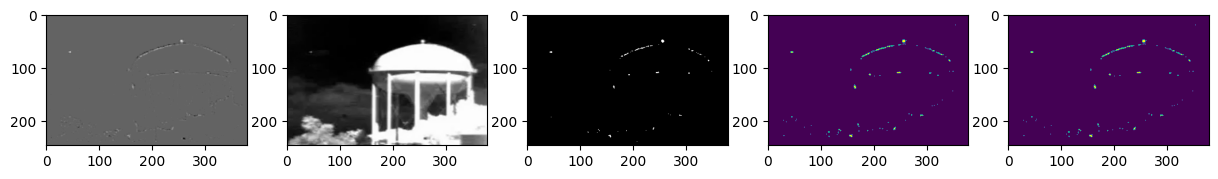

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(img,'gray')
plt.subplot(1,5,2)
plt.imshow(ori_img,'gray')
plt.subplot(1,5,3)
plt.imshow(th1,'gray')
plt.subplot(1,5,4)
plt.imshow(can2)
plt.subplot(1,5,5)
plt.imshow(can2)

In [9]:
img

array([[99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       ...,
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99]], dtype=uint8)

### 2.抑制虚警 

In [1]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(can2.astype("uint8"), connectivity=4, ltype=None)
ys=[]
xs=[]
for i in range(len(stats)-1):
    if stats[i+1,4]>=2:
        y=int(centroids[i+1][0])
        x=int(centroids[i+1][1]) 
        ys.append(y)
        xs.append(x)

NameError: name 'cv2' is not defined

In [11]:

d=15
write=False
img_patches=np.zeros([len(ys),2*d+1,2*d+1])
can_patches=np.zeros([len(ys),2*d+1,2*d+1])
ssm_patches=np.zeros([len(ys),2*d+1,2*d+1])
ssm_patches2=np.zeros([len(ys),2*d+1,2*d+1])
ssm_patches3=np.zeros([len(ys),2*d+1,2*d+1])
pstnn_patches=np.zeros([len(ys),2*d+1,2*d+1])
for i in range(len(ys)):
    y=ys[i]
    x=xs[i]
    img_s=ori_img[:,:,0]
    img_patches[i]=img_s[x-d:x+d+1,y-d:y+d+1]
    pstnn_patches[i]=img[x-d:x+d+1,y-d:y+d+1]
    can_patches[i]=can2[x-d:x+d+1,y-d:y+d+1]
    ssm_patches[i]=cal_ssm(can2[x-d:x+d+1,y-d:y+d+1])
    ssm_patches2[i]=cal_ssm2(can2[x-d:x+d+1,y-d:y+d+1],img_s[x-d:x+d+1,y-d:y+d+1],150)
    ssm_patches3[i]=cal_ssm3(can2[x-d:x+d+1,y-d:y+d+1],img_s[x-d:x+d+1,y-d:y+d+1],0.4)
    if write==True:
        patch=img_s[x-d:x+d+1,y-d:y+d+1]
        patch_ssm=cal_ssm(can2[x-d:x+d+1,y-d:y+d+1])
        cv2.imwrite("./data_xulie/patch_img/"+imgname[:-4]+"_{}_y{}_x{}.png".format(i+1,y,x),patch)
        cv2.imwrite("./data_xulie/patch_ssm/"+imgname[:-4]+"_{}_y{}_x{}.png".format(i+1,y,x),patch_ssm)
        cv2.imwrite("./data_xulie/patch_can/"+imgname[:-4]+"_{}_y{}_x{}.png".format(i+1,y,x),can_patches[i]*255)

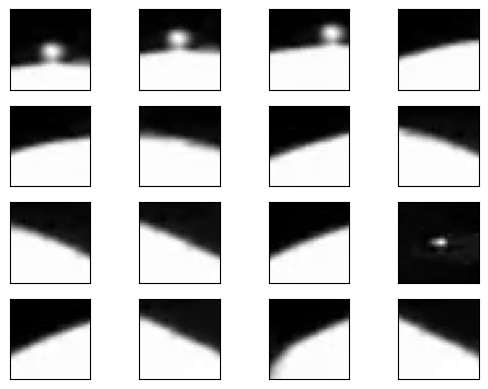

In [12]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(img_patches[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

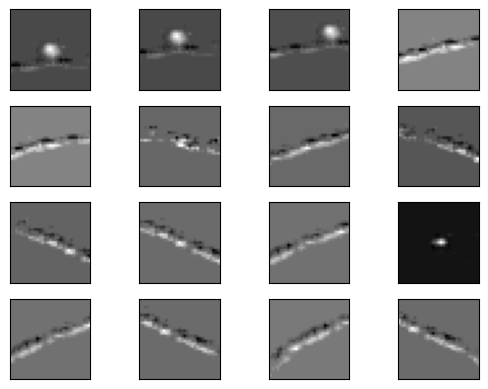

In [13]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(pstnn_patches[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

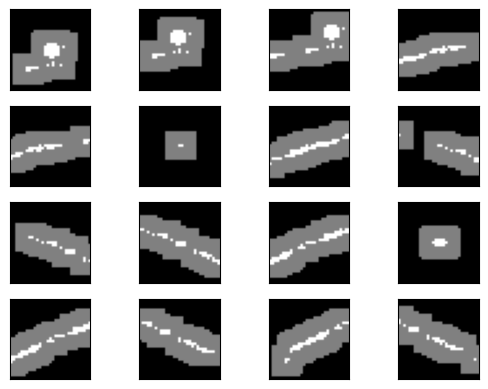

In [14]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(ssm_patches[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

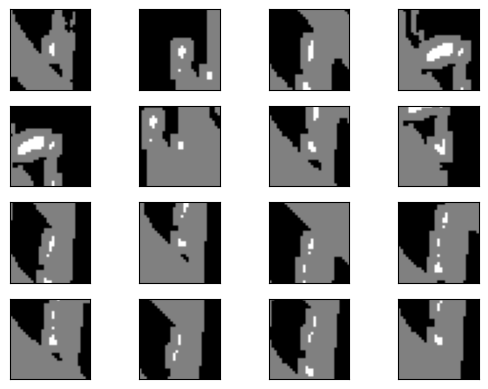

In [15]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(ssm_patches2[i],'gray')
    #plt.subplot(4,4,i+1),plt.imshow(ssm_patches2[i])
    plt.xticks([]),plt.yticks([])
plt.show()

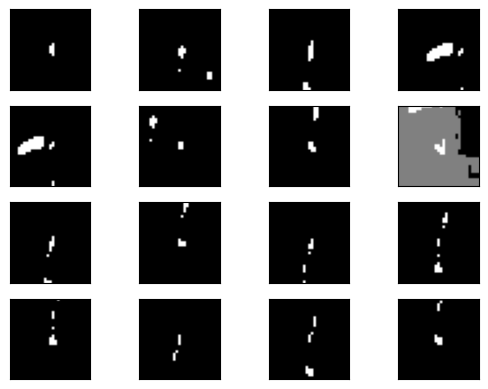

In [16]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(ssm_patches3[i],'gray')
    #plt.subplot(4,4,i+1),plt.imshow(ssm_patches2[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [15]:
from pymatting.util.util import sanity_check_image
from pymatting.laplacian.laplacian import make_linear_system
from pymatting.laplacian.rw_laplacian import rw_laplacian
from pymatting.preconditioner.jacobi import jacobi
from pymatting.solver.cg import cg

In [20]:
from pymatting.util.util import sanity_check_image
from pymatting.laplacian.laplacian import make_linear_system
from pymatting.laplacian.rw_laplacian import rw_laplacian
from pymatting.laplacian.knn_laplacian import knn_laplacian
from pymatting.preconditioner.jacobi import jacobi
from pymatting.solver.cg import cg
alphaes=np.zeros([len(ys),2*d+1,2*d+1])
scale = 1.0
for i in range(len(ys)):
    #image = load_image("./data_xulie/patch_img/"+name, "RGB", scale, "box")
    #can = load_image("./data_xulie/patch_can/"+name, "GRAY", scale, "nearest")
    cv2.imwrite("./jixiebi/147.jpg",img_patches[i])
    #print(can)
    image=load_image("./jixiebi/147.jpg", "RGB", scale, "box")
    trimap=ssm_patches[i]   
    #print(trimap)
    preconditioner=None
    if preconditioner is None:
        preconditioner = jacobi

    sanity_check_image(image)

    #A, b = make_linear_system(rw_laplacian(image, sigma=0.25), trimap)
    try:
        A, b = make_linear_system(knn_laplacian(image,n_neighbors=[20, 5],distance_weights=[0.4], kernel="binary"), trimap)
        x = cg(A, b, M=preconditioner(A), maxiter=2000)
        alpha = np.clip(x, 0, 1).reshape(trimap.shape)
        
    except:
        alpha=np.zeros(trimap.shape)
    alphaes[i]=alpha
    #alphaes[i] = estimate_alpha_rw(image, trimap)
    os.remove("./jixiebi/147.jpg")

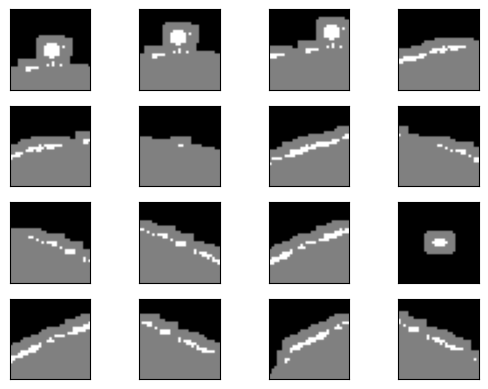

In [21]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(ssm_patches2[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

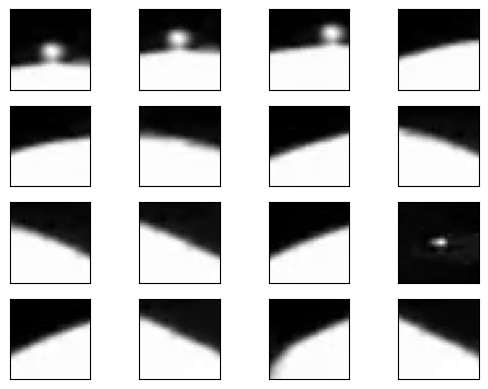

In [64]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(img_patches[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

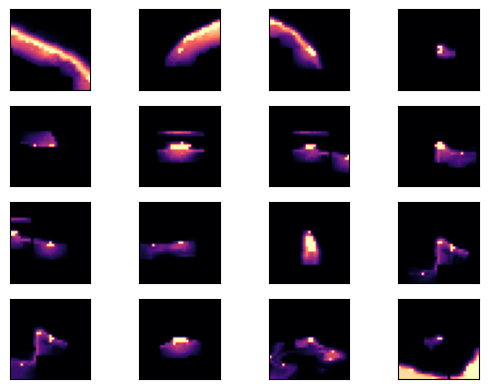

In [27]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(alphaes[i+16],'magma')
    plt.xticks([]),plt.yticks([])
plt.show()

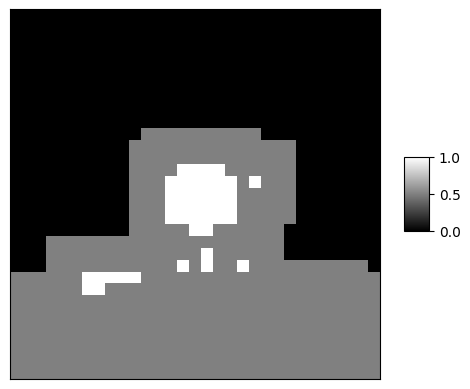

In [65]:
test_num=0
fig, ax = plt.subplots()
surf=ax.imshow(ssm_patches2[test_num],'gray')
plt.xticks([]),plt.yticks([])
# 添加一个颜色条形图展示颜色区间
fig.colorbar(surf, shrink=0.2, aspect=3)

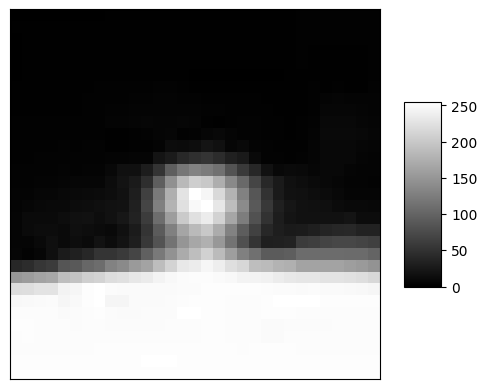

In [34]:
fig, ax = plt.subplots()
surf=ax.imshow(img_patches[test_num],'gray')
plt.xticks([]),plt.yticks([])
# 添加一个颜色条形图展示颜色区间
fig.colorbar(surf, shrink=0.5, aspect=5)

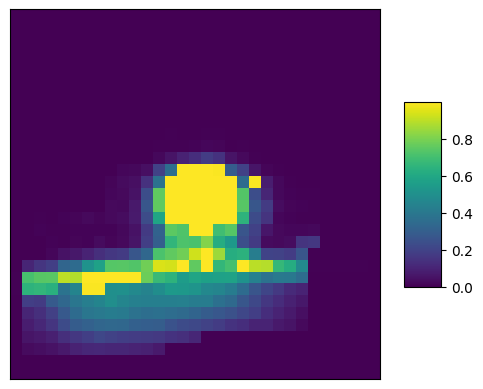

In [35]:
fig, ax = plt.subplots()
surf=ax.imshow(alphaes[test_num])
plt.xticks([]),plt.yticks([])
# 添加一个颜色条形图展示颜色区间
fig.colorbar(surf, shrink=0.5, aspect=5)

IndexError: index 3 is out of bounds for axis 0 with size 3

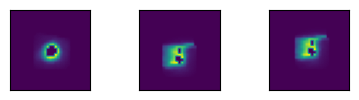

In [344]:
for i in range(16):
    ssmmask=np.where(ssm_patches[i]==0.5,1,0)
    plt.subplot(4,4,i+1),plt.imshow(alphaes[i]*ssmmask)
    plt.xticks([]),plt.yticks([])
plt.show()

In [36]:
import math



def XJYZ(img_tar,img_a,img_tri,c):
    mask_tri=np.where(img_tri==0.5,1,0)
    affi=img_a*mask_tri
    yinzi=c*affi.sum()/mask_tri.sum()+1
    print(yinzi)
    #mask_tar=np.where(img_tri>=0.5,1,0)*(yinzi-1)+1
    mask_tar=np.where(img_tri>=0.5,1,0)*(yinzi-1)+1
    return img_tar/mask_tar

def XJYZ2(img_tar,img_a,img_tri,c):
    mask_tri=np.where(img_tri==0.5,1,0)
    affi=img_a*mask_tri
    yinzi=c*affi.sum()/mask_tri.sum()+1
    return img_tar/yinzi

def XJYZ3(img_tar,img_a,img_tri,c):
    mask_tri=np.where(img_tri==0.5,1,0)
    affi=img_a*mask_tri
    yinzi=c*affi.sum()/mask_tri.sum()+1
    print(yinzi)
    #mask_tar=np.where(img_tri>=0.5,1,0)*(yinzi-1)+1
    
    b = np.bincount(img_tar.reshape(-1).astype('uint8'))  
    m=np.argmax(b)
    mask_tar=np.where(img_tar>m,1,0)*(yinzi-1)+1
    return img_tar/mask_tar

def XJYZ4(img_tar,img_a,img_tri,k=10):
    mask_tri=np.where(img_tri==0.5,1,0)
    affi=img_a*mask_tri
    yinzi=affi.sum()
    print(yinzi)
    yizhi=math.exp(-0.25*(yinzi-k))
    #mask_tar=np.where(img_tri>=0.5,1,0)*(yinzi-1)+1
    print("yizhi:",yizhi)
    
    b = np.bincount(img_tar.reshape(-1).astype('uint8'))  
    m=np.argmax(b)
    mask_tar=np.where(img_tar>m,1,0)*(yizhi-1)+1
    return img_tar*mask_tar

#np.tanh(x)
def XJYZ5(img_tar,img_a,img_tri,k=15,C=1):
    mask_tri=np.where(img_tri==0.5,1,0)
    affi=img_a*mask_tri
    affisum=affi.sum()
    print(affisum)
    yizhi=np.tanh(affisum-k)
    print("yizhi:",yizhi)    
    b = np.bincount(img_tar.reshape(-1).astype('uint8'))  
    m=np.argmax(b)
    mask_tar=np.where(img_tar>m,(1-C*yizhi)*(img_tar-m)+m,img_tar)
    if   affisum<k:
        mask_tar=np.where(img_a>0.4,mask_tar.max(),mask_tar)
    return mask_tar#img_tar-C*img_tar*mask_tar

In [67]:
targets=np.zeros(pstnn_patches.shape)
for i in range(len(pstnn_patches)):
    targets[i]=XJYZ5(pstnn_patches[i],alphaes[i],ssm_patches[i],k=22,C=1)

82.95410624940085
yizhi: 1.0
90.72644328931216
yizhi: 1.0
168.63648710418005
yizhi: 1.0
133.98587692508318
yizhi: 1.0
131.15537969960343
yizhi: 1.0
8.607423321122015
yizhi: -0.99999999999534
138.41987248079388
yizhi: 1.0
71.63488502027771
yizhi: 1.0
104.72462124005934
yizhi: 1.0
165.49499344505318
yizhi: 1.0
149.06135546011333
yizhi: 1.0
20.051343095089923
yizhi: -0.9602147787718139
153.87129615895765
yizhi: 1.0
157.21643233716566
yizhi: 1.0
129.5314361731023
yizhi: 1.0
150.11183269259027
yizhi: 1.0
157.1290765421084
yizhi: 1.0
80.68101889358927
yizhi: 1.0
68.8863021502098
yizhi: 1.0
8.367961801850322
yizhi: -0.9999999999971133
17.35624408689662
yizhi: -0.9998148709140792
39.31447636352752
yizhi: 0.9999999999999982
33.18957162412004
yizhi: 0.999999999618151
25.197555636704077
yizhi: 0.9966661663819699
30.64392723759542
yizhi: 0.9999999379116412
24.742527033136053
yizhi: 0.9917376532033232
24.637089251977056
yizhi: 0.9898078800639899
29.208579319203793
yizhi: 0.9999989041848099
36.49315

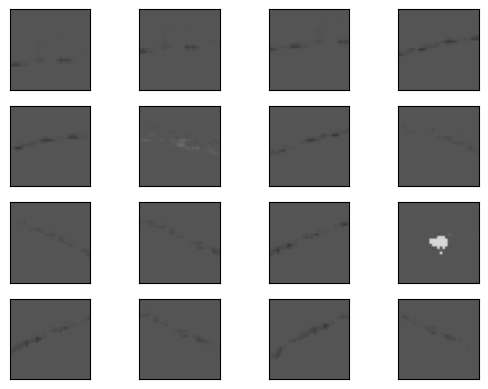

In [68]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(targets[i],'gist_gray',vmin=-100, vmax=500)
    plt.xticks([]),plt.yticks([])
plt.show()

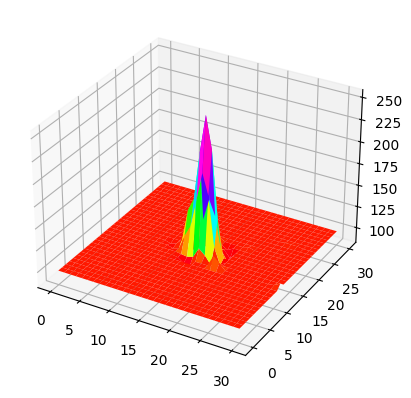

In [69]:
from matplotlib import cm
img_gray=pstnn_patches[11]
Y = np.arange(0, np.shape(img_gray)[0], 1)
X = np.arange(0, np.shape(img_gray)[1], 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, img_gray, cmap=cm.gist_rainbow)
plt.show()


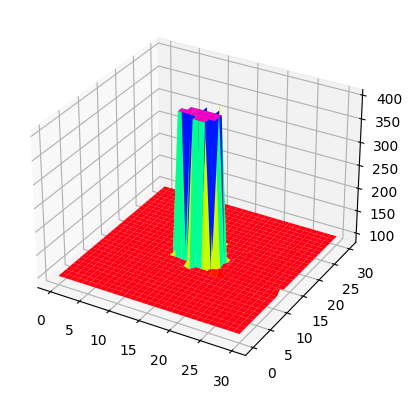

In [70]:
from matplotlib import cm
img_gray=targets[11]
Y = np.arange(0, np.shape(img_gray)[0], 1)
X = np.arange(0, np.shape(img_gray)[1], 1)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, img_gray, cmap=cm.gist_rainbow)
plt.show()

In [148]:
# 曲面图，默认情况下，它将以纯色的阴影着色，但它也通过提供 cmap 参数支持颜色映射。
# rcount 和 ccount kwargs 都默认为 50，决定了每个方向使用的最大样本数。如果输入数据较大，则会将其下采样（通过切片）到这些点数。
# 为了最大限度地提高渲染速度，将 rstride 和 cstride 分别设置为行数减 1 和列数减 1 的除数。例如，给定 51 行，rstride 可以是 50 的任何除数。
# 同样，设置 rstride 和 cstride 等于 1（或 rcount 和 ccount 等于行数和列数）可以使用优化路径。
def surface_3d():
    # 3D 表面（颜色图）演示绘制使用冷暖色图着色的 3D 表面。通过使用 antialiased=False 使表面变得不透明。
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator
    import numpy as np

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # 构建数据
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X ** 2 + Y ** 2)
    Z = np.sin(R)

    # 绘制曲面图
    # 绘制使用冷暖色图着色的 3D 表面。通过使用 antialiased=False 使表面变得不透明。
    surf = ax.plot_surface(X, Y, Z, cmap=cm.brg,
                           linewidth=0, antialiased=False)

    # 定制z轴
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # 添加一个颜色条形图展示颜色区间
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

    # 绘制曲面图
    # 绘制使用冷暖色图着色的 3D 表面。通过使用 antialiased=True 使表面变得透明。
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)
    # 定制z轴
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')
    # 添加一个颜色条形图展示颜色区间
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


In [112]:
def surface_3d_1(img_gray,name):
    # 3D 表面（颜色图）演示绘制使用冷暖色图着色的 3D 表面。通过使用 antialiased=False 使表面变得不透明。
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator
    import numpy as np

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # 构建数据
    Y = np.arange(0, np.shape(img_gray)[0], 1)
    X = np.arange(0, np.shape(img_gray)[1], 1)
    X, Y = np.meshgrid(X, Y)

    # 绘制曲面图
    # 绘制使用冷暖色图着色的 3D 表面。通过使用 antialiased=False 使表面变得不透明。
    
    norm = matplotlib.colors.Normalize(vmin=60,vmax=120)
    surf = ax.plot_surface(X, Y, img_gray, cmap=cm.rainbow,
                           linewidth=0, antialiased=False,norm=norm)

    # 定制z轴
    ax.set_zlim(60, 120)
    ax.zaxis.set_major_locator(LinearLocator(7))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.00f}')

    # 定制x轴
    ax.set_xlim(-1, 19)
    ax.xaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.xaxis.set_major_formatter('{x:.00f}')
    # 定制y轴
    ax.set_ylim(-1, 19)
    ax.yaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.yaxis.set_major_formatter('{x:.00f}')    
    # 添加一个颜色条形图展示颜色区间
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    #plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    plt.savefig('./result_3D/'+name)
    plt.show()
    
    
    



IndexError: index 2 is out of bounds for axis 0 with size 2

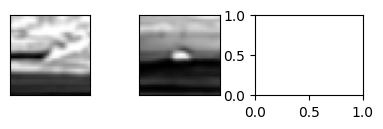

In [179]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(img_patches[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

In [209]:
result=img.copy()/1#img\th1
for i in range(len(ys)):
    y=ys[i]
    x=xs[i]
    result[x-d:x+d+1,y-d:y+d+1]=targets[i]

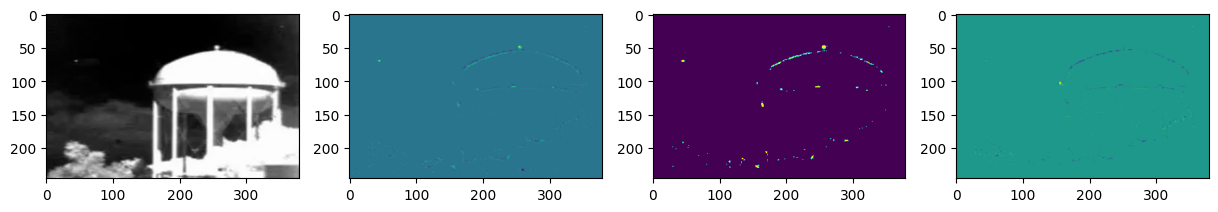

In [210]:
#result=np.where(result>1,1,0)
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(ori_img)
plt.subplot(1,4,2)
plt.imshow(img)
plt.subplot(1,4,3)
plt.imshow(can2)
plt.subplot(1,4,4)
cai=20
BACK=99
caibian=True
if caibian==True:
    result[:,:cai]=BACK
    result[:,-1*cai:]=BACK
    result[:cai,:]=BACK
    result[-1*cai:,:]=BACK
plt.imshow(result)

In [301]:
result.max()

230

In [204]:
img

array([[99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       ...,
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99],
       [99, 99, 99, ..., 99, 99, 99]], dtype=uint8)

In [183]:
cv2.imwrite("./datasets1-7/duibishiyan/"+imgname,result)

True

# 多帧

In [269]:
import re
root3_path="D:\\Jupyter\\r_walk\\data_xulie\\data_label\\data6.txt"
def openreadtxt(file_name):
    data = []
    file = open(file_name,'r')  #打开文件
    file_data = file.readlines() #读取所有行
    for row in file_data:
        tmp_list = row.split(' ') #按‘，’切分每行的数据
        #tmp_list[-1] = tmp_list[-1].replace('\n',',') #去掉换行符
        data.append(tmp_list) #将每行数据插入data中
    return data 
data = openreadtxt(root3_path)

In [270]:
root1_path="D:\\Jupyter\\r_walk\\data_xulie\\data6\\"
#root1_path="F:\\DataTest.rw\\data6\\"
root2_path="D:\\Jupyter\\r_walk\\data_xulie\\pstnn_data6\\"
#root2_path="F:\\DataTest.rw\\pstnn_data6\\"
N=399
k=0
scale = 1.0
shuchupingjia=True
image_series=np.zeros([N,256,256])
zesults=np.zeros([N,256,256])
y_pre=[]
y_true=[]
for j in range(N):
    name="{}.bmp".format(j+k)
    ori_img=cv2.imdecode(np.fromfile(root1_path+name,dtype=np.uint8),cv2.IMREAD_COLOR)#[:,:,1]
    pstnn_img = cv2.imread(root2_path+name,1)
    img=pstnn_img[:,:,1]
    can2=cal_SSM(img,bugandiao=False,caibian=True)
    image_series[j]=ori_img[:,:,1]
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(can2.astype("uint8"), connectivity=4, ltype=None)
    ys=[]
    xs=[]
    for i in range(len(stats)-1):
        if stats[i+1,4]>=2:
            y=int(centroids[i+1][0])
            x=int(centroids[i+1][1]) 
            ys.append(y)
            xs.append(x)
    d=8
    img_patches=np.zeros([len(ys),2*d+1,2*d+1])
    can_patches=np.zeros([len(ys),2*d+1,2*d+1])
    ssm_patches=np.zeros([len(ys),2*d+1,2*d+1])
    alphaes=np.zeros([len(ys),2*d+1,2*d+1])
    zhixinges=np.zeros([len(ys),2*d+1,2*d+1])

    maes=re.findall(r'\d+', data[k+j+1][0])
    y_oj=int(maes[3])
    x_oj=int(maes[4])
    result=np.zeros(img.shape)
    for i in range(len(ys)):
        y=ys[i]
        x=xs[i]
        img_s=ori_img[:,:,0]
        img_patches[i]=img_s[x-d:x+d+1,y-d:y+d+1]
        ssm_patches[i]=cal_ssm2(can2[x-d:x+d+1,y-d:y+d+1],img_s[x-d:x+d+1,y-d:y+d+1],135)

        cv2.imwrite("./jixiebi/147.jpg",img_patches[i])
        #print(can)
        image=load_image("./jixiebi/147.jpg", "RGB", scale, "box")
        trimap=ssm_patches[i]   
        #print(trimap)
        preconditioner=None
        if preconditioner is None:
            preconditioner = jacobi

        sanity_check_image(image)
        try:
            A, b = make_linear_system(rw_laplacian(image, sigma=0.25), trimap)
            x_ = cg(A, b, M=preconditioner(A), maxiter=2000)
            alpha = np.clip(x_, 0, 1).reshape(trimap.shape)

        except:
            alpha=np.zeros(trimap.shape)
        alphaes[i]=alpha
        #alphaes[i] = estimate_alpha_rw(image, trimap)
        os.remove("./jixiebi/147.jpg")  
        zhixinges[i]=cal_zhixingdu(ssm_patches[i],alphaes[i])   
        result[x-d:x+d+1,y-d:y+d+1]=zhixinges[i]
        #预测结果
        #print(j,i,y,x,zhixinges[i].max())
        y_pre.append(zhixinges[i].max())
        if (y_oj-y)*(y_oj-y)+(x_oj-x)*(x_oj-x)<=2:
            y_true.append(1)
        else:
            y_true.append(0)
                          
    zesults[j]=result
    if shuchupingjia==True:
        image_ss=ori_img[:,:,1]
        sg_in=np.var(image_ss[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        sg_out=np.var(result[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])        
        print("BFS:",sg_in/sg_out)
        Ut_in=image_ss[x_oj,y_oj]
        Ub_in=np.mean(image_ss[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        Ucb_in=np.var(image_ss[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        SCR_in=np.abs(Ut_in-Ub_in)/Ucb_in

        Ut_out=result[x_oj,y_oj]
        Ub_out=np.mean(result[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        Ucb_out=np.var(result[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        SCR_out=np.abs(Ut_out-Ub_out)/Ucb_out  
        print("SCRG:",SCR_out/SCR_in)

BFS: 10624901.884466708
SCRG: 2005.9833919214523
BFS: 1038336.2385711324
SCRG: 1577.1735035827949


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7792\3695279080.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  print("BFS:",sg_in/sg_out)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7792\3695279080.py:91: RuntimeWarning: invalid value encountered in double_scalars
  SCR_out=np.abs(Ut_out-Ub_out)/Ucb_out


BFS: inf
SCRG: nan
BFS: 9720499.624698125
SCRG: 4029.0342282258775
BFS: 385889.44197010226
SCRG: 1570.9253677560616
BFS: 422196.67056111485
SCRG: 1727.9380250629242
BFS: 878201.0732535047
SCRG: 2056.431624059682
BFS: 847361.8163753217
SCRG: 2284.479734181868
BFS: 482885.12798005034
SCRG: 1993.0262752750396
BFS: 978449.1660893939
SCRG: 2247.4539044236026
BFS: 964281.9530698325
SCRG: 1986.9577893110932
BFS: 1002150.1221357333
SCRG: 2071.248219346841
BFS: 975551.174428823
SCRG: 1844.860679196721
BFS: 987163.2506915078
SCRG: 2030.3293977381713
BFS: 820542.0705197855
SCRG: 1646.5128913503484
BFS: 4448601.699259407
SCRG: 826.7226572684418
BFS: 22736418.89606417
SCRG: 3745.721481888749
BFS: 578339.4032529899
SCRG: 1530.954311857537
BFS: 502814.9228090576
SCRG: 1316.8212206529558
BFS: 13750473.585952327
SCRG: 4889.9222614824575
BFS: inf
SCRG: nan
BFS: 2956268.0012972574
SCRG: 20.181647172104665
BFS: 6081146.289407232
SCRG: 1635.6560808625793
BFS: 551642.6833200995
SCRG: 187.345204136001
BFS: 2

BFS: 50858.134034943934
SCRG: 290.59291401943045
BFS: 96710.87361476112
SCRG: 333.21451578853925
BFS: 56458.02096875294
SCRG: 305.62793949584494
BFS: 49507.60693947087
SCRG: 287.05523914491374
BFS: 82467.33756766275
SCRG: 229.67726180143364
BFS: inf
SCRG: nan
BFS: 85667.06681316705
SCRG: 254.07414195208537
BFS: 99722.42621062606
SCRG: 323.80111294133343
BFS: 49845.49818128339
SCRG: 300.2632451457226
BFS: 52405.828333204845
SCRG: 259.29024167737066
BFS: 82817.80282994648
SCRG: 276.83493228872464
BFS: 62714.8096502984
SCRG: 326.9537474776657
BFS: 92086.53013590859
SCRG: 259.6147791470731
BFS: 107414.06966519568
SCRG: 302.8625722461794
BFS: 61088.720489319574
SCRG: 309.12978665842485
BFS: 60473.84544169174
SCRG: 268.04168065859693
BFS: 90510.55196469612
SCRG: 294.7163077306241
BFS: 62027.269359007834
SCRG: 319.37324418383434
BFS: 61293.1670119681
SCRG: 291.4486151274641
BFS: 64889.32163218426
SCRG: 319.7081326077307
BFS: 61548.28442521074
SCRG: 332.52458361934356
BFS: 62144.69104402551
SC

BFS: 1901466839.3893266
SCRG: 2858.997436569233
BFS: 70204427.01469357
SCRG: 778.2258128431401
BFS: 250759.26169248275
SCRG: 1796.0214387273927
BFS: 46616924.01130075
SCRG: 634.2124593520072
BFS: 189222562.11561954
SCRG: 1424.804510829806
BFS: 50328193.70652322
SCRG: 380.8674623084066
BFS: 150623622.0595278
SCRG: 878.8967190456852
BFS: inf
SCRG: nan
BFS: 736416228893395.8
SCRG: 1012776.0036865897
BFS: 3004220531.2295337
SCRG: 6339.024590873799
BFS: 1077086278.1501327
SCRG: 2510.6321003854105
BFS: 851103409.8576835
SCRG: 1900.8559633247173
BFS: 52166798824.74248
SCRG: 12994.375284148544
BFS: inf
SCRG: nan
BFS: inf
SCRG: nan
BFS: inf
SCRG: nan
BFS: inf
SCRG: nan


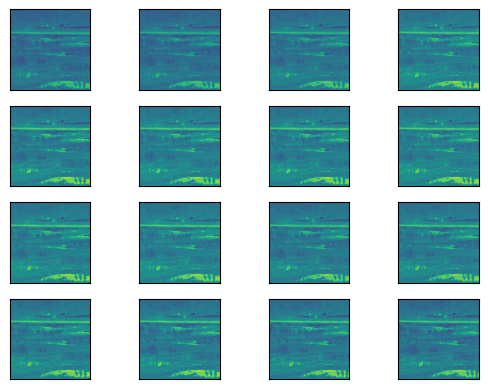

In [265]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(image_series[i])
    plt.xticks([]),plt.yticks([])
plt.show()

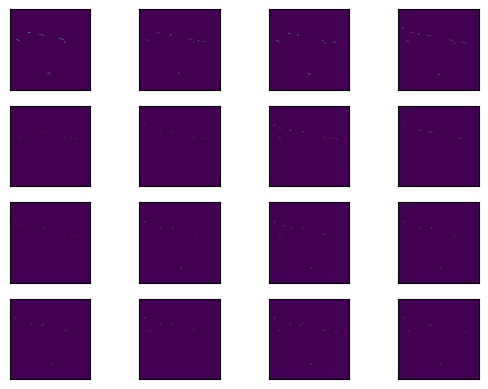

In [271]:
for i in range(16):
    plt.subplot(4,4,i+1),plt.imshow(zesults[i])
    plt.xticks([]),plt.yticks([])
plt.show()

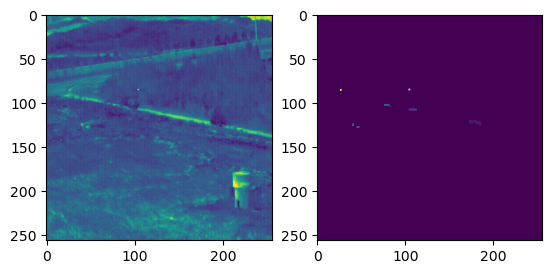

In [278]:
i=50
plt.subplot(1,2,1)
plt.imshow(image_series[i])
plt.subplot(1,2,2)
plt.imshow(zesults[i])

NameError: name 'zesults' is not defined

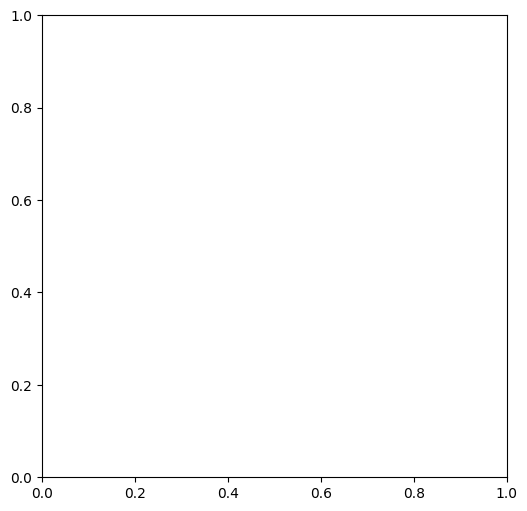

In [1]:
import matplotlib.pyplot as plt
from IPython import display
#横纵坐标设置，是否固定横纵坐标
#%matplotlib qt5
dy=5
dx=5
for i in range(349):
    fig,ax=plt.subplots(figsize=(6,6), dpi=100)
    
    ras=zesults[i]
    y=np.where(ras==ras.max())[0][0]
    x=np.where(ras==ras.max())[1][0]
    #1
    x_list1=np.arange(x-dx, x+dx+1, 1)
    y_list1=np.ones([2*dx+1]).astype('uint8')*y+dy
    #2
    x_list2=np.arange(x-dx, x+dx+1, 1)
    y_list2=np.ones([2*dx+1]).astype('uint8')*y-dy
    #3
    y_list3=np.arange(y-dy, y+dy+1, 1)
    x_list3=np.ones([2*dx+1]).astype('uint8')*x-dx
    #4
    y_list4=np.arange(y-dy, y+dy+1, 1)
    x_list4=np.ones([2*dx+1]).astype('uint8')*x+dx
    plt.imshow(image_series[i],"gray")
    display.clear_output(wait=True)
    #print(X[i],Y[i],X_pre10[1+i],Y_pre10[1+i])
    plt.plot(x_list1, y_list1,'y--')
    plt.plot(x_list2, y_list2,'y--')
    plt.plot(x_list3, y_list3,'y--')
    plt.plot(x_list4, y_list4,'y--')
    #plt.legend(loc='upper right', fontsize=12))
    plt.show()
    plt.pause(0.1)

#### 对比试验 

In [1]:
def ROC_result(name,T):
    N=100
    k=100
    y_pres=[]
    y_trues=[]
    d=8
    for j in range(N):
       # results = cv2.imread('D:\\Jupyter\\r_walk\\data_xulie\\'+name+'\\{}.bmp'.format(j+k),1)
        results = cv2.imread('F:\\DataTest.rw\\'+name+'\\{}.bmp'.format(j+k),1)
        mask=results[:,:,1]
        can=np.where(mask>T,1,0)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(can.astype("uint8"), connectivity=4, ltype=None)
        ys=[]
        xs=[]
        maes=re.findall(r'\d+', data[k+j+1][0])
        y_oj=int(maes[3])
        x_oj=int(maes[4])
        for i in range(len(stats)-1):
            if stats[i+1,4]>=2:
                y=int(centroids[i+1][0])
                x=int(centroids[i+1][1]) 
                ys.append(y)
                xs.append(x)
        for i in range(len(ys)):
            y=ys[i]
            x=xs[i]
            y_pres.append(mask[x,y])
            if (y_oj-y)*(y_oj-y)+(x_oj-x)*(x_oj-x)<=2:
                y_trues.append(1)
            else:
                y_trues.append(0)     
    FPR_, recall_, thresholds_ = roc_curve(y_trues,y_pres, pos_label=1)
    print(name+"_AUC:",roc_auc_score(y_trues,y_pres))
    return FPR_,recall_

In [2]:
def cal_BFS_SCRG(name,se="data20"):
    N=10
    k=100
    y_pres=[]
    y_trues=[]
    d=20
    print(name,"++++++++++++++++++++++++++++++++++++++++++++",name)
    for j in range(N):
       # results = cv2.imread('D:\\Jupyter\\r_walk\\data_xulie\\'+name+'\\{}.bmp'.format(j+k),1)
        results = cv2.imread('F:\\DataTest.rw\\'+name+'\\{}.bmp'.format(j+k),1)
        ori_=cv2.imread('F:\\DataTest.rw\\'+se+'\\{}.bmp'.format(j+k),1)
        ori=ori_[:,:,1]
        mask=results[:,:,1]
        maes=re.findall(r'\d+', data[k+j+1][0])
        y_oj=int(maes[3])
        x_oj=int(maes[4])
        print(name+'\\{}.bmp'.format(j+k))
        #BFS
        out_img=mask[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1]
        in_img=ori[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1]
        sg_in=np.var(in_img)
        sg_out=np.var(out_img)
        print("BFS:",sg_in/sg_out)
        
        #SCRG
        Ut_in=ori[x_oj,y_oj]
        Ub_in=np.mean(ori[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        Ucb_in=np.var(ori[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        SCR_in=np.abs(Ut_in-Ub_in)/Ucb_in

        Ut_out=mask[x_oj,y_oj]
        Ub_out=np.mean(mask[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        Ucb_out=np.var(mask[x_oj-d:x_oj+d+1,y_oj-d:y_oj+d+1])
        SCR_out=np.abs(Ut_out-Ub_out)/Ucb_out  
        print("SCRG:",SCR_out/SCR_in)    
    return 0

In [260]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
#RW
FPR, recall, thresholds = roc_curve(y_true,y_pre, pos_label=1)
print("pstnn-RW:",roc_auc_score(y_true,y_pre))
#cal_RW_BFS(zesults,se="data5")
#其他
FPR1, recall1 = ROC_result('pstnn_data20',115)
cal_BFS_SCRG("pstnn_data20","data20")
FPR2, recall2 = ROC_result('NRAM_data20',15)
cal_BFS_SCRG("NRAM_data20","data20")
FPR3, recall3 = ROC_result('lcm_data20',115)
cal_BFS_SCRG("lcm_data20","data20")
FPR4, recall4 = ROC_result('IPI_data20',100)
cal_BFS_SCRG("IPI_data20","data20")
#FPR5, recall5 = ROC_result('LogTFNN_data5',115)
FPR5, recall5 = ROC_result('MPCM_data20',10) 
cal_BFS_SCRG("MPCM_data20","data20")
FPR6, recall6 = ROC_result('RIPT_data20',50)
cal_BFS_SCRG("RIPT_data20","data20")
FPR7, recall7 = ROC_result('TMESNN_data20',20)
cal_BFS_SCRG("TMESNN_data20","data20")
FPR8, recall8 = ROC_result('TRCR_data20',80)
cal_BFS_SCRG("TRCR_data20","data20")

pstnn-RW: 0.8831114146300038
pstnn_data20_AUC: 0.9220851688693098
pstnn_data20 ++++++++++++++++++++++++++++++++++++++++++++ pstnn_data20
pstnn_data20\100.bmp
BFS: 2.833328712392213
SCRG: 2.8314738768059424
pstnn_data20\101.bmp
BFS: 2.7468160068403593
SCRG: 2.6949621811287274
pstnn_data20\102.bmp
BFS: 2.393680652975687
SCRG: 2.594841090283748
pstnn_data20\103.bmp
BFS: 2.2715262674561014
SCRG: 2.4948395790844407
pstnn_data20\104.bmp
BFS: 2.191140803661245
SCRG: 2.3826318937188637
pstnn_data20\105.bmp
BFS: 2.3133592958476785
SCRG: 2.5445526832682175
pstnn_data20\106.bmp
BFS: 2.9243873443399706
SCRG: 3.2878827780143562
pstnn_data20\107.bmp
BFS: 2.8503371101148165
SCRG: 3.1703243654187583
pstnn_data20\108.bmp
BFS: 1.9767400475899752
SCRG: 2.1594746193114407
pstnn_data20\109.bmp
BFS: 2.8891984323551823
SCRG: 3.086085221479874
NRAM_data20_AUC: 0.9052608376193975
NRAM_data20 ++++++++++++++++++++++++++++++++++++++++++++ NRAM_data20
NRAM_data20\100.bmp
BFS: 1.5399649031976528
SCRG: 2.40929947499

0

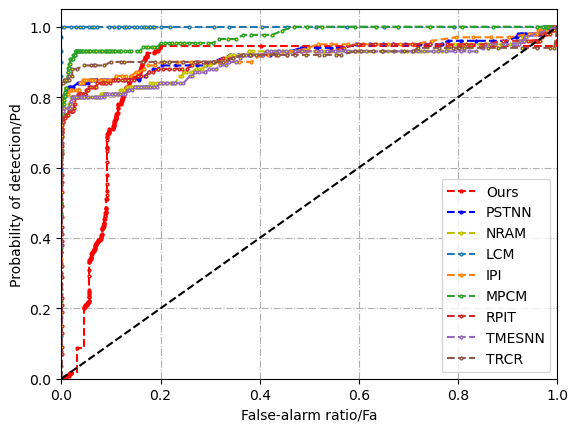

In [261]:
min = 0
max = 1
#area = roc_auc_score(y_true,y_pre)
plt.figure()
#plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
#plt.plot(FPR1, recall1, 'r--',marker='o',markersize=2,markerfacecolor='red',label='Ours' )
plt.plot(FPR, recall, 'r--',marker='o',markersize=2,markeredgecolor = 'red',markerfacecolor=(0, 0, 0, 0),drawstyle='steps-post',label='Ours' )
plt.plot(FPR1, recall1, 'b--',marker='o',markersize=2,markerfacecolor='blue',label='PSTNN' )
plt.plot(FPR2, recall2, 'y--',marker='o',markersize=2,markerfacecolor='yellow',label='NRAM' )
plt.plot(FPR3, recall3, '--',marker='o',markersize=2,markerfacecolor='yellow',label='LCM' )
plt.plot(FPR4, recall4, '--',marker='o',markersize=2,markerfacecolor='yellow',label='IPI' )
plt.plot(FPR5, recall5, '--',marker='o',markersize=2,markerfacecolor='yellow',label='MPCM' )
plt.plot(FPR6, recall6, '--',marker='o',markersize=2,markerfacecolor='yellow',label='RPIT' )
plt.plot(FPR7, recall7, '--',marker='o',markersize=2,markerfacecolor='yellow',label='TMESNN' )
plt.plot(FPR8, recall8, '--',marker='o',markersize=2,markerfacecolor='yellow',label='TRCR' )
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([0.0, 1.0])#不是在0，1是因为怕挤着不太好看
plt.ylim([0.0, 1.05]) 
plt.grid(linestyle='-.')
plt.xlabel('False-alarm ratio/Fa',size=10)
plt.ylabel('Probability of detection/Pd',size=10)
plt.legend(loc="lower right",prop = {'size':10})
plt.savefig('F:\\DataTest.rw\\roc_curve\\data20_roc.png')
plt.show()


### 读取txt文件

In [202]:
root3_path="D:\\Jupyter\\r_walk\\data_xulie\\data_label\\data8.txt"


In [60]:
def openreadtxt(file_name):
    data = []
    file = open(file_name,'r')  #打开文件
    file_data = file.readlines() #读取所有行
    for row in file_data:
        tmp_list = row.split(' ') #按‘，’切分每行的数据
        #tmp_list[-1] = tmp_list[-1].replace('\n',',') #去掉换行符
        data.append(tmp_list) #将每行数据插入data中
    return data 
data = openreadtxt(root3_path)

In [56]:
#1-n
data[1][0]

'frame:0\t1\tobject:1\t71\t109\n'

In [59]:
import re
i=231
maes=re.findall(r'\d+', data[i][0])
y=int(maes[3])
x=int(maes[4])
#print(re.findall(r'\d+', data[1][0]),y,x)  # ['aab', 'aab']

In [41]:
y

100

In [58]:
root1_path="D:\\Jupyter\\r_walk\\data_xulie\\data5\\"
root2_path="D:\\Jupyter\\r_walk\\data_xulie\\pstnn_data5\\"
N=20
k=230
scale = 1.0
image_series=np.zeros([N,256,256])
zesults=np.zeros([N,256,256])
for j in range(N):
    name="{}.bmp".format(j+k)
    ori_img=cv2.imdecode(np.fromfile(root1_path+name,dtype=np.uint8),cv2.IMREAD_COLOR)#[:,:,1]
    pstnn_img = cv2.imread(root2_path+name,1)
    img=pstnn_img[:,:,1]
    can2=cal_SSM(img,bugandiao=False,caibian=True)
    image_series[j]=ori_img[:,:,1]
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(can2.astype("uint8"), connectivity=4, ltype=None)
    ys=[]
    xs=[]
    for i in range(len(stats)-1):
        if stats[i+1,4]>=2:
            y=int(centroids[i+1][0])
            x=int(centroids[i+1][1]) 
            ys.append(y)
            xs.append(x)
    d=8
    img_patches=np.zeros([len(ys),2*d+1,2*d+1])
    can_patches=np.zeros([len(ys),2*d+1,2*d+1])
    ssm_patches=np.zeros([len(ys),2*d+1,2*d+1])
    alphaes=np.zeros([len(ys),2*d+1,2*d+1])
    zhixinges=np.zeros([len(ys),2*d+1,2*d+1])
    result=np.zeros(img.shape)
    for i in range(len(ys)):
        y=ys[i]
        x=xs[i]
        img_s=ori_img[:,:,0]
        img_patches[i]=img_s[x-d:x+d+1,y-d:y+d+1]
        ssm_patches[i]=cal_ssm2(can2[x-d:x+d+1,y-d:y+d+1],img_s[x-d:x+d+1,y-d:y+d+1],135)

        cv2.imwrite("./jixiebi/147.jpg",img_patches[i])
        #print(can)
        image=load_image("./jixiebi/147.jpg", "RGB", scale, "box")
        trimap=ssm_patches[i]   
        #print(trimap)
        preconditioner=None
        if preconditioner is None:
            preconditioner = jacobi

        sanity_check_image(image)

        A, b = make_linear_system(rw_laplacian(image, sigma=0.25), trimap)
        try:
            x_ = cg(A, b, M=preconditioner(A), maxiter=2000)
            alpha = np.clip(x_, 0, 1).reshape(trimap.shape)

        except:
            alpha=np.zeros(trimap.shape)
        alphaes[i]=alpha
        #alphaes[i] = estimate_alpha_rw(image, trimap)
        os.remove("./jixiebi/147.jpg")  
        zhixinges[i]=cal_zhixingdu(ssm_patches[i],alphaes[i])       
        result[x-d:x+d+1,y-d:y+d+1]=zhixinges[i]
    zesults[j]=result